# Importing Libraries

In [1]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as func
from pyspark.sql.types import StringType,FloatType
import nltk
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from wordcloud import WordCloud
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re
from pyspark.sql.functions import lit

# Reading the Data

In [2]:
spark = SparkSession.builder.master("local[*]").config("spark.memory.offHeap.enabled",True).config("spark.memory.offHeap.size","10G").config('spark.driver.memory','10G').appName('yelp-reviews').getOrCreate()
df = spark.read.csv("/home/ubuntu/lab5/""twitter_sentiment_train.csv", inferSchema=True)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/04 22:27:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



# Renaming Columns

In [4]:
df = df.withColumnRenamed('_c0','target').withColumnRenamed('_c1','id').withColumnRenamed('_c2','date')\
  .withColumnRenamed('_c3','flag').withColumnRenamed('_c4','user').withColumnRenamed('_c5','text')
df.show(5)
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

+------+----------+--------------------+--------+---------------+--------------------+
|target|        id|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



There are 1600000 rows and  6 columns in the dataset.


# Checking for missing values

In [5]:
df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()
# Handle duplicates
df = df.dropDuplicates()

# Drop unnecessary columns

In [6]:
drop_cols= ("id","date","flag","user")
df = df.drop(*drop_cols)
df.show(5, truncate = False)

+------+-----------------------------------------------------------------------------------------------+
|target|text                                                                                           |
+------+-----------------------------------------------------------------------------------------------+
|0     |     angry                                                                                     |
|0     |   @Beansummer                                                                                 |
|0     |   awwwww i really hate this.                                                                  |
|0     |   i am soooo sad...at this point of night i'd be cuddling with jonathan like i did for 4 years|
|0     |  Hand quilting it is then...                                                                  |
+------+-----------------------------------------------------------------------------------------------+
only showing top 5 rows



# Changing value of a Positive tweet from 4 to 1

In [7]:
df.createOrReplaceTempView('temp')
df = spark.sql('SELECT CASE target WHEN 4 THEN 1.0  ELSE 0 END AS label, text FROM temp')
df.tail(5)

[Row(label=Decimal('1.0'), text='your such a good snger @ddlovato!  xoxo'),
 Row(label=Decimal('1.0'), text='yum yum pizza take out '),
 Row(label=Decimal('1.0'), text="yummy ! drake's on this episode of degrassi "),
 Row(label=Decimal('1.0'), text='zzzzzzzzz ... then Terra Brunch in Malibu ! Come on folks.... beautiful weather on a Sunday.... come for brunch in Malibu '),
 Row(label=Decimal('1.0'), text='저�?� #goodnight! ')]

In [8]:
df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|800000|
|  1.0|800000|
+-----+------+



# Text Preprocessing

In [9]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
#Use pysparks function udf (user defined functions) to create our own preprocess function
clean_text = func.udf(lambda x: preprocess(x), StringType())

df = df.withColumn('text_cleaned',clean_text(func.col("text")))
df.show(5)

+-----+--------------------+--------------------+
|label|                text|        text_cleaned|
+-----+--------------------+--------------------+
|  0.0|               angry|               angry|
|  0.0|         @Beansummer|          beansummer|
|  0.0|   awwwww i reall...|  awwwww really hate|
|  0.0|   i am soooo sad...|soooo sad point n...|
|  0.0|  Hand quilting i...|       hand quilting|
+-----+--------------------+--------------------+
only showing top 5 rows



In [12]:
df = df.drop("text")

# Displaying WordCloud

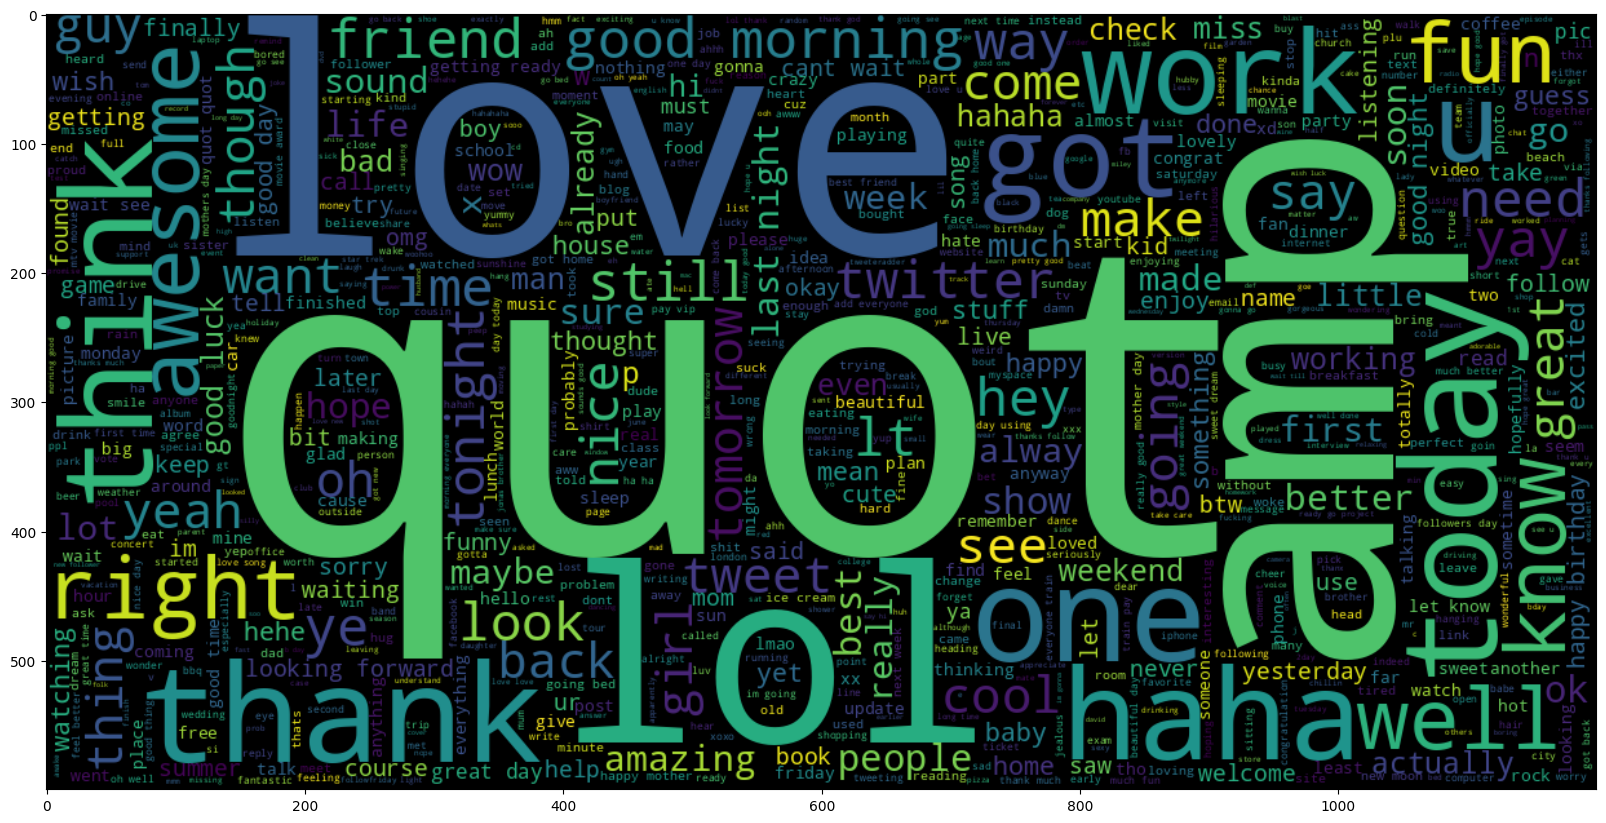

In [13]:
pandas_df = df.toPandas()
plt.figure(figsize = (20,16)) 
wc = WordCloud(max_words = 800 , width = 1200 , height = 600).generate(" ".join(pandas_df[pandas_df["label"]==1.0].text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')

# Preparing Model for Data Building

In [14]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(df)
words_tokens.show(5)

+-----+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|
+-----+--------------------+--------------------+
|  0.0|               angry|             [angry]|
|  0.0|          beansummer|        [beansummer]|
|  0.0|  awwwww really hate|[awwwww, really, ...|
|  0.0|soooo sad point n...|[soooo, sad, poin...|
|  0.0|       hand quilting|    [hand, quilting]|
+-----+--------------------+--------------------+
only showing top 5 rows



# Applying CountVectorizer

In [15]:
count = CountVectorizer(inputCol="words_tokens", outputCol="rawFeatures")
model = count.fit(words_tokens)
featurizedData = model.transform(words_tokens)
featurizedData.show(5)

22/12/04 22:36:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


+-----+--------------------+--------------------+--------------------+
|label|        text_cleaned|        words_tokens|         rawFeatures|
+-----+--------------------+--------------------+--------------------+
|  0.0|               angry|             [angry]|(262144,[1580],[1...|
|  0.0|          beansummer|        [beansummer]|      (262144,[],[])|
|  0.0|  awwwww really hate|[awwwww, really, ...|(262144,[18,69,25...|
|  0.0|soooo sad point n...|[soooo, sad, poin...|(262144,[3,21,43,...|
|  0.0|       hand quilting|    [hand, quilting]|(262144,[666,2422...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



# Applying TF-IDF

In [16]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show(5) 

22/12/04 22:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/12/04 22:39:13 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[1580],[7...|
|  0.0|      (262144,[],[])|
|  0.0|(262144,[18,69,25...|
|  0.0|(262144,[3,21,43,...|
|  0.0|(262144,[666,2422...|
+-----+--------------------+
only showing top 5 rows



In [17]:
df_final = rescaledData.select("label", "features")

In [18]:
seed = 42 
trainDF, testDF = df_final.randomSplit([0.7,0.3],seed)

In [19]:
trainDF.groupby("label").count().show()

22/12/04 22:39:38 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:39:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/12/04 22:39:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/12/04 22:41:27 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
+-----+------+
|label| count|
+-----+------+
|  0.0|560011|
|  1.0|560238|
+-----+------+



In [20]:
lr = LogisticRegression(labelCol = "label", featuresCol = "features",maxIter = 10)
final_model = lr.fit(trainDF) 

22/12/04 22:42:01 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:43:43 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:44:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/04 22:44:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/12/04 22:45:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/04 22:45:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/12/04 22:45:30 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:33 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:34 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:35 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:37 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:38 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:39 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:40 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:41 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/12/04 22:45:42 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


In [21]:
predictions = final_model.transform(testDF)
pred = predictions.toPandas()
pred.head()

22/12/04 22:46:36 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


,label,features,rawPrediction,probability,prediction
0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2649508924627325, 0.2649508924627325]","[0.43414706098960326, 0.5658529390103968]",1.0
1,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2649508924627325, 0.2649508924627325]","[0.43414706098960326, 0.5658529390103968]",1.0
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2649508924627325, 0.2649508924627325]","[0.43414706098960326, 0.5658529390103968]",1.0
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2649508924627325, 0.2649508924627325]","[0.43414706098960326, 0.5658529390103968]",1.0
4,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2649508924627325, 0.2649508924627325]","[0.43414706098960326, 0.5658529390103968]",1.0


In [22]:
y_true = pred['label'].astype('float')
y_pred = pred['prediction']

In [23]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75    239989
         1.0       0.75      0.78      0.76    239762

    accuracy                           0.76    479751
   macro avg       0.76      0.76      0.76    479751
weighted avg       0.76      0.76      0.76    479751



Run Model on Yelp Data

In [24]:
reviewdf = spark.read.json("/home/ubuntu/data/yelp_academic_dataset_review.json")
reviewdf.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [25]:
reviewdf.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in reviewdf.columns]).toPandas().head()
# Handle duplicates
reviewdf = reviewdf.dropDuplicates()

In [26]:
drop_cols= ("cool","date","funny","useful","review_id","stars","user_id")
reviewdf = reviewdf.drop(*drop_cols)
reviewdf.show(5)

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|Cu8ysHKiZmJKRY9nF...|These guys do goo...|
|eL4lyE7LNoXEMvpcJ...|This was a tough ...|
|EqEcDeXqIq1YwnzHg...|Similar experienc...|
|_RwlMTw9uFeOkfX9C...|Ick.  That sums u...|
|WIv5kTb_P3jnngPkM...|They have combina...|
+--------------------+--------------------+
only showing top 5 rows



In [27]:
clean_text = func.udf(lambda x: preprocess(x), StringType())

reviewdf = reviewdf.withColumn('text_cleaned',clean_text(func.col("text")))
reviewdf.show(5)
reviewdf = reviewdf.drop("text")

+--------------------+--------------------+--------------------+
|         business_id|                text|        text_cleaned|
+--------------------+--------------------+--------------------+
|Cu8ysHKiZmJKRY9nF...|These guys do goo...|guys good work ti...|
|eL4lyE7LNoXEMvpcJ...|This was a tough ...|tough one merits ...|
|EqEcDeXqIq1YwnzHg...|Similar experienc...|similar experienc...|
|_RwlMTw9uFeOkfX9C...|Ick.  That sums u...|ick sums experien...|
|WIv5kTb_P3jnngPkM...|They have combina...|combination deals...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [28]:
tokenizer = Tokenizer(inputCol="text_cleaned", outputCol="words_tokens")
words_tokens = tokenizer.transform(reviewdf)
words_tokens.show(5) 

+--------------------+--------------------+--------------------+
|         business_id|        text_cleaned|        words_tokens|
+--------------------+--------------------+--------------------+
|Cu8ysHKiZmJKRY9nF...|guys good work ti...|[guys, good, work...|
|eL4lyE7LNoXEMvpcJ...|tough one merits ...|[tough, one, meri...|
|EqEcDeXqIq1YwnzHg...|similar experienc...|[similar, experie...|
|_RwlMTw9uFeOkfX9C...|ick sums experien...|[ick, sums, exper...|
|WIv5kTb_P3jnngPkM...|combination deals...|[combination, dea...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [29]:
count = CountVectorizer(inputCol="words_tokens", outputCol="rawFeatures")
count_model = count.fit(words_tokens)
featurizedData = count_model.transform(words_tokens)
featurizedData.show(5)

22/12/04 23:25:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+--------------------+--------------------+--------------------+--------------------+
|         business_id|        text_cleaned|        words_tokens|         rawFeatures|
+--------------------+--------------------+--------------------+--------------------+
|Cu8ysHKiZmJKRY9nF...|guys good work ti...|[guys, good, work...|(262144,[1,5,10,5...|
|eL4lyE7LNoXEMvpcJ...|tough one merits ...|[tough, one, meri...|(262144,[5,6,7,8,...|
|EqEcDeXqIq1YwnzHg...|similar experienc...|[similar, experie...|(262144,[2,3,4,6,...|
|_RwlMTw9uFeOkfX9C...|ick sums experien...|[ick, sums, exper...|(262144,[0,1,2,5,...|
|WIv5kTb_P3jnngPkM...|combination deals...|[combination, dea...|(262144,[2,4,8,10...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [30]:
# featurizedData = featurizedData.withColumn("label", lit(0.0))

In [31]:
# featurizedData.show(5)

In [32]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# rescaledData.select("label", "features").show(5) 

22/12/04 23:27:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/12/04 23:47:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [33]:
yelpRevinput_df = rescaledData.select("features","business_id","words_tokens")


In [34]:
predictions = final_model.transform(yelpRevinput_df)
predictions_cleaned = predictions.select("business_id","prediction")
predictions.show(5)
# pred = predictions.toPandas()
# pred.show(5)

22/12/04 23:48:19 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|            features|         business_id|        words_tokens|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|(262144,[1,5,10,5...|Cu8ysHKiZmJKRY9nF...|[guys, good, work...|[-0.7061354044627...|[0.33045333618263...|       1.0|
|(262144,[5,6,7,8,...|eL4lyE7LNoXEMvpcJ...|[tough, one, meri...|[10.3678305510849...|[0.99996857359132...|       0.0|
|(262144,[2,3,4,6,...|EqEcDeXqIq1YwnzHg...|[similar, experie...|[3.45679414627029...|[0.96943311193489...|       0.0|
|(262144,[0,1,2,5,...|_RwlMTw9uFeOkfX9C...|[ick, sums, exper...|[6.85470675637445...|[0.99894662994846...|       0.0|
|(262144,[2,4,8,10...|WIv5kTb_P3jnngPkM...|[combination, dea...|[3.26589294769935...|[0.96324002277683...|       0.0|
+--------------------+--------------------+-------------

In [35]:
from pyspark import SparkContext
SparkContext.setSystemProperty('spark.executor.memory', '10g')


In [36]:
predictions_cleaned.createOrReplaceTempView("pred")
sqlDF = spark.sql("SELECT business_id, avg(prediction) as rating from pred GROUP BY business_id")

22/12/04 23:50:13 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


In [1]:
pred.to_parquet('/home/ubuntu/data/pred.parquet.gzip', compression='gzip')  



NameError: name 'spark' is not defined